# Resident activity detection using Facebook Prophet:

*This notebook is based on the following [tutorial](https://medium.com/analytics-vidhya/time-series-forecast-anomaly-detection-with-facebook-prophet-558136be4b8d) written by Paul Lo. It makes use of the open-source project [Prophet](https://facebook.github.io/prophet/), a forecasting procedure implemented in R and Python, based on the paper of [Taylor and Letham, 2017](https://peerj.com/preprints/3190/).*

**Goal of the script:**

Here, we aim to the detect activity of resident over time, based on the data provided by the smart sensor. Since the CO2 level is very well correlated with the presence of a human, we mostly focused on analysing the CO2 data.
We aim to identify activity such as:
* Someone goes to bed (the CO2 level decreases or increases, depending on where is the sensor and stay stable)
* Someone wakes up in the morning
* Someone wakes up nightly for a bathroom breaks (the CO2 level transiently changes and comes back to baseline)
* Unknown activities that nevertheless occur regularly

**Motivations to use a forecasting method to detect activity:**

In the notebook Data_Exploration.ipynb, the data was plotted in 2 and 3 dimensions. The limitations were the following:
- 2D plotting could be used to detect transient changes in time series, but the significant changes between day and night baselines make the detection difficult.
- 3D plotting and k-means clustering between three parameters (light, CO2, temperature or humidity) might provide information on the physical relationships between the parameters, but not on the activity of the resident.

Since ederly people tends to have the same activity rythm every day (e.g. wakes up, has a walk, goes to bed at the same time of the day), we reasoned that the trend in CO2 should be quite similar between days. This seasonality is well handled by the algorith [Prophet](https://facebook.github.io/prophet/) from Facebook, dedicated to perform 'time series forecasting' from seasonal data.

![Prophet_figure.png](Prophet_figure.png)
**Figure 1: General principle of using a forecasting method to detect a resident activity**

We took advantage of the continuous recording of CO2 from the ambient sensor, to model the activity patterns of resident. The data from the ten last days of recording were used to make a model of the typical activity pattern of the resident. For instance, if the sensor is located in the bedroom of the resident, the model will predict that the CO2 will increase and stay stable from the time the resident goes to bed until he wakes up and leaves the bedroom.

A GridSearch function was designed to optimize the model by tuning the hyperparameters. The GridSearch returned a table containing the tested parameters and sorted according to the **Mean Average Percentage Error**. Then the optimized model is used to predict how the activity pattern of today should be. In the **Figure 1**, the predicted pattern from the model is shown in blue. By comparing the predicted results with the latest measurements, we detect how often, and when, a resident exhibits an unpredictable activity. The interpretation of the relationship between predicted and measured CO2 level is discussed at the end of the notebook.


**Structure of the script:**

This script is designed to:
1. Load a device-specific dataset:
    - either located in the folder ../data/interim of the repository
    - or located in an Amazon S3 bucket.
2. Pre-visualize one part of the device-specific dataset and choose:
    - the parameter to study
    - begin and end of dataframe
    - the period of data averaging (example: use one point every 1min instead of 1 point every 20sec)
3. Training a Prophet model:
    * **Run a single instance** with specific parameters of Prophet
    * **Hyperparameter tuning**: execute a GridSearch to test several ranges of parameters of Prophet. This returns a table of the tested parameters and the median of the mean average percentage error calculated on the predicted data. Since the data varies from one device to the other, this function helps to determine the best "device-specific" parameters for prediction. As an example, I ran 4 tests using the device 33:
        * Test 1: Testing different sampling periods, changepoint_prior_scale and daily_fo of the Prophet model
        * Test 2: Testing different shorter sampling periods, changepoint_prior_scale and daily_fo of the Prophet model
        * Test 3:  Testing with different training period duration, changepoint_prior_scale and daily_fo of the Prophet model
        * Test 4: Testing different training periods, daily_fo of the Prophet model



**Run the script:**

How to run the script:
* Load the script in jupyter notebook.
* **To load the data:** Choose your device number. If you want to use the interactive plot function, uncomment the line ```# %matplotlib notebook```
* **To visualize the data before analysis:** Look at the data using df_generator. The arguments are:
```python
df, predict_n, today_index, lookback_n = df_generator(
                df_dev, # device-specific dataframe
                parameter, # String. among 'light', 'temperature', 'humidity', 'co2'
                begin, # String. Day of the beginning of the new dataframe
                end, # String. Day of the end of the new dataframe
                sampling_period_st, # String. Duration of bin for data downsampling
                sampling_period_num, # Float. Duration of bin for data downsampling
                graph=None, # Set to None to show the graph and a value not to show it
                predict_day=1 # Number of days predicted. 1 by default
)
```
* **To predict the data:** Use and customize the cell containing:
```python
df_p, df_pred = prophet(
                df_dev,
                device,
                parameter='co2',
                begin='2019-03-26',
                end='2019-04-03',
                sampling_period_min=5,
                graph=1, 
                predict_day=1,
                interval_width=0.6, # Anomaly threshold
                changepoint_prior_scale=0.01, # Adjusting trend flexibility
                daily_fo = 12 # Fourier order defined for the seasonality
)
```
* **Hyperparameter tuning:** Use and customize the cell containing:

```python
# Define the parameters to test
prophet_grid = {'df_dev' : [df_dev],
                'device' : [device],
                'parameter' : ['co2'],
                'begin' : ['2019-03-22', '2019-03-24'],
                'end' : ['2019-04-03'],
                'sampling_period_min' : [1, 5, 30],
                'graph' : [1],
                'predict_day' : [1],
                'interval_width' : [0.6],
                'changepoint_prior_scale' : list((0.01, 15)),
                'daily_fo' : [3, 9, 18],
               }

# Run GridSearch_Prophet
mape_table = GridSearch_Prophet(list(ParameterGrid(prophet_grid)), metric='mape')
```

**Conclusions and working directions:**

* See at the end of the notebook

> Questions:
> Contact Guillaume Azarias at guillaume.azarias@hotmail.com

## 1 - Import the relevant library

In [1]:
import pandas as pd
import numpy as np
import time
import re

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# To use the interactive plots, uncomment the following lines
%matplotlib notebook 

from datetime import datetime, timedelta
from pytz import timezone

In [2]:
import fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [3]:
fbprophet.__version__

'0.6'

In [4]:
from sklearn.model_selection import ParameterGrid
import itertools
from random import sample

In [5]:
# Import the functions from the helper.py
from helper import load_ds, df_dev_formater, find_index, df_generator, prophet_fit, prophet_plot, get_outliers, execute_cross_validation_and_performance_loop, prophet, GridSearch_Prophet

## Load a device-specific dataset

**Note on the dataframe**
- To speed up the processing, this script was designed to work with a device-specific dataframe that should be located in the folder ../data/interim. The user enters the number of the device in a two-digit string format ('01', '02'... '51') and follows the instructions.
- If the device-specific dataframes do not exist yet, it will be automatically generated. This script expects to find the following files in the folder ../Data/raw:'
        * raw_data_part1.csv
        * raw_data_part2.csv
        * raw_data_part3.csv
        * raw_data_part4.csv
        * raw_data_part5.csv

### Possibility 1: Load data from the Amazon S3 bucket:

This is a function to be able to use a cloud to store data such as AWS. Here is the
[link to the company bucket on Amazon](removed_link) *(credentials required)*

In [ ]:
import boto3, os
import s3fs
s3 = boto3.client('s3') # aws client object

In [ ]:
path = 's3://company/interim/device04_alldays.csv'

In [ ]:
dummy_df = pd.read_csv(path)

In [ ]:
dummy_df.head(2)

### Possibility 2:  Load a local file

Check report:
##############################################
['Device contained in the dataset: device24']
['Tenant using the device: tenant04']

Data types:
device                                object
tenant                                object
ds             datetime64[ns, Europe/Zurich]
light                                float64
temperature                          float64
humidity                             float64
co2                                  float64
dtype: object

Available data from the 2019-04-10 to the 2019-07-29.

Showing the dataframe. Use it to find the time window you would like to investigate:


<IPython.core.display.Javascript object>


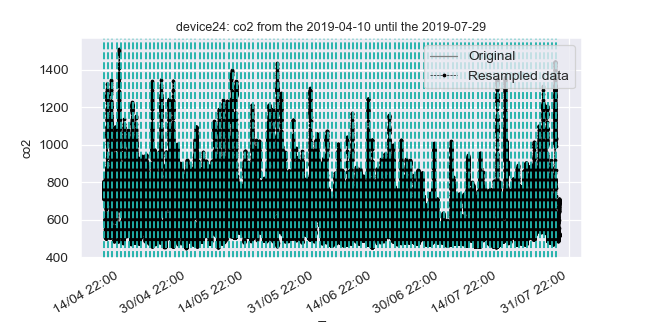

Full dataset: 2019-04-10 to the 2019-07-29. Analysed data the 2019-04-10 to the 2019-07-29.


In [6]:
# Enter the number of the device as a string with two digits and execute the cell
device_nb = '24'

# Load the device-specific dataframe. Show the most important information
assert isinstance(device_nb, str) and len(device_nb)==2 and sum(d.isdigit() for d in device_nb)==2, 'WARNING: device_nb must be a string of 2-digits!'
assert int(device_nb)>=1 and int(device_nb)<=51, 'This device does not belong to the dataframe'
device, df_dev = load_ds(device_nb)

# Convert the variable device from a np.array to a string
regex = re.compile('[^A-Za-z0-9]')
device = regex.sub('', str(device))

# Show the full device-specific dataframe
print('\nShowing the dataframe. Use it to find the time window you would like to investigate:')
start = df_dev['ds'][0].strftime('%Y-%m-%d')
last = df_dev['ds'][df_dev.shape[0]-1].strftime('%Y-%m-%d')
df, predict_n, today_index, lookback_n = df_generator(df_dev, device, 'co2', start, last,  '1T', 0.016)
plt.show()

**NOTE: *This figure is meant to be used in the interactive mode of jupyter notebook. It will be displayed small and with green horizontal lines on the Gitlab. To use the interactive mode, uncomment the line # %matplotlib notebook and run the notebook*.**

In [28]:
df.to_csv('device_24_full.csv')

## Data visualisation

Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-26 to the 2019-04-03.


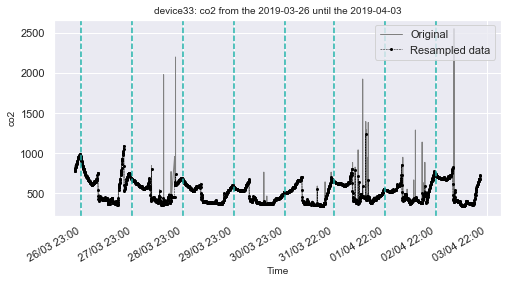

In [7]:
start = '2019-03-26'
last = '2019-04-03'
df, predict_n, today_index, lookback_n = df_generator(df_dev, device, 'co2', start, last,  '5T', 0.08)

In [8]:
find_index(df, '2019-03-08', '20:30')

2291


## Model training

### Running a Prophet instance

Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-26 to the 2019-04-03.
o Trained on the data from the 2019-03-26 to the 2019-04-02 (6 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


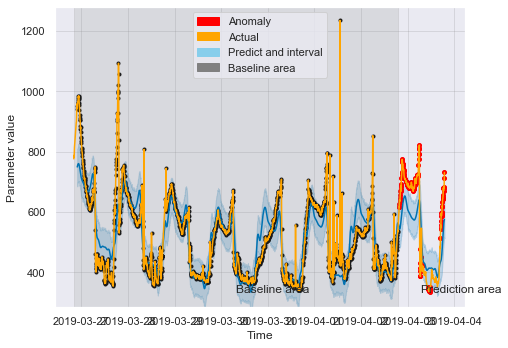

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-04-01 06:54:43.412000 and 2019-04-01 18:54:43.412000


<Figure size 432x288 with 0 Axes>

In [9]:
# Single instance check
df_p, df_pred = prophet(
            df_dev,
            device,
            parameter='co2',
            begin='2019-03-26',
            end='2019-04-03',
            sampling_period_min=5,
            graph=1, 
            predict_day=1,
            interval_width=0.6,
            changepoint_prior_scale=0.01,
            daily_fo = 12
)

**Plotting the Cross validation performance metrics over time**

In [10]:
df_p.dtypes

horizon     timedelta64[ns]
mse                 float64
rmse                float64
mae                 float64
mape                float64
mdape               float64
coverage            float64
dtype: object

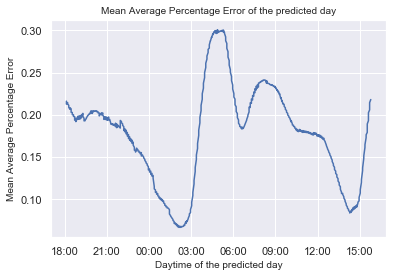

In [11]:
today = datetime.today()
df_p['dt'] = today + df_p['horizon']
plt.close()
ax = sns.lineplot(x="dt", y="mape", data=df_p)
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel('Daytime of the predicted day', fontsize=10)
plt.ylabel('Mean Average Percentage Error', fontsize=10)
plt.title('Mean Average Percentage Error of the predicted day', fontsize=10)
plt.show()

Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


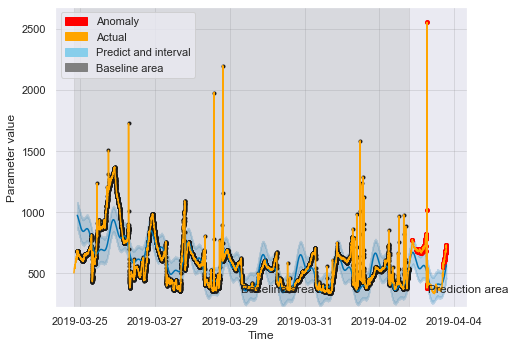

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000


<Figure size 432x288 with 0 Axes>

In [12]:
# Single instance example
df_p, df_pred = prophet(
            df_dev,
            device,
            parameter='co2',
            begin='2019-03-24',
            end='2019-04-03',
            sampling_period_min=1,
            graph=1, 
            predict_day=1,
            interval_width=0.6,
            changepoint_prior_scale=0.001,
            daily_fo = 3
)

### Running a GridSearch of Prophet: Hyperparameter optimization

**See the result analysis in ../docs/Prophet_notes.md**

See this the [official Prophet documentation](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#fourier-order-for-seasonalities) and this [tutorial](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) for a comprehensive guide of seasonality settings.

**Parameters to optimize**
* *interval_width*=0.9, Anomaly threshold or tolerance. If you decrease it you increase the sensitivity to detect outliers.
* *yearly_seasonality*=False, weekly_seasonality=False, daily_seasonality=False *--> Use your own seasonility.*
* *changepoint_prior_scale*=0.01 # Adjusting trend flexibility. low *--> toward overfit. Does not make sense to have more than 0.1. Just increasing tolerance.*
* *model.add_seasonality*(name='daily', period=1, (you can add as many seasonalities as you want. Period (float number)in days.
    * fourier_order=12 (it is better to use a fourier order>10)
    * prior_scale=0.1
* *n_changepoints* seems to be a parameter that would be helpful in this project (did not have the time to check it yet).

**Test 1: Testing different sampling periods, changepoint_prior_scale and daily_fo of the Prophet model**

In [20]:
# GridSearch.
start_time = time.time()

# Parameters
prophet_grid = {'df_dev' : [df_dev],
                'device' : [device],
                'parameter' : ['co2'],
                'begin' : ['2019-03-22', '2019-03-24'],
                'end' : ['2019-04-03'],
                'sampling_period_min' : [1, 5, 30],
                'graph' : [1],
                'predict_day' : [1],
                'interval_width' : [0.6],
                'changepoint_prior_scale' : list((0.01, 15)), # list(np.arange(0.01,30,1).tolist()),
                'daily_fo' : [3, 9, 18],
#                 'holidays_prior_scale' : list((1000,100,10,1,0.1)),
               }

# Run GridSearch_Prophet
mape_table = GridSearch_Prophet(list(ParameterGrid(prophet_grid)), metric='mape')


end_time = time.time()
dur_min = int((end_time - start_time)/60)


print('GridSearch finished '+ str(dur_min) + " minutes.")



prophet_instance nb 0
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 1
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 2
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-23 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 3
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 4
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 5
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-23 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 6
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 7
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 8
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-23 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 9
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 10
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 11
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-23 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 12
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 13
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 14
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-23 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 15
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 16
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 17
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-23 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 18
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 19
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 20
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 21
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 22
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 23
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 24
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 25
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 26
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 27
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 28
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 29
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 30
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 31
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 32
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:29:58.738000 and 2019-04-01 18:29:58.738000



prophet_instance nb 33
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 34
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:54:43.412000 and 2019-04-01 18:54:43.412000



prophet_instance nb 35
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:29:58.738000 and 2019-04-01 18:29:58.738000


GridSearch finished 98 minutes.


In [30]:
# Almost 3min per model on average
mape_table.shape[0]

36

In [22]:
mape_table.to_csv('dev33_co2_2019-04-03_SP_IW_FO_CPS.csv')

In [24]:
mape_table.sort_values('mape_average')

,device,parameter,begin,end,sampling_period_min,interval_width,daily_fo,changepoint_prior_scale,mape_average
11,[device33],co2,2019-03-22,2019-04-03,30,0.6,3,15.00,0.116839
10,[device33],co2,2019-03-22,2019-04-03,5,0.6,3,15.00,0.122786
9,[device33],co2,2019-03-22,2019-04-03,1,0.6,3,15.00,0.123446
0,[device33],co2,2019-03-22,2019-04-03,1,0.6,3,0.01,0.123622
17,[device33],co2,2019-03-22,2019-04-03,30,0.6,18,15.00,0.128037
29,[device33],co2,2019-03-24,2019-04-03,30,0.6,3,15.00,0.128436
14,[device33],co2,2019-03-22,2019-04-03,30,0.6,9,15.00,0.128777
15,[device33],co2,2019-03-22,2019-04-03,1,0.6,18,15.00,0.129947
16,[device33],co2,2019-03-22,2019-04-03,5,0.6,18,15.00,0.130079
32,[device33],co2,2019-03-24,2019-04-03,30,0.6,9,15.00,0.131068


In [41]:
mape_table.to_csv('dev33_co2_2019-04-03_SP_IW_FO_CPS_2.csv')

**Conclusions**

'changepoint_prior_scale' (CPS)
	- greater than 1 just make a aberrantly wide prediction: 15 IS NOT GOOD !
	- Higher than 1 significantly decreases the accuracy!
	- try changepoint_prior_scale : 0.001, 0.01, 0.1

'sampling_period_min' : [1, 5, 30]:
	- you miss events with 30min, but are faster
	- try 1, 2 and 5

'begin':
	- 10 days is better than 6 days but much longer analysis
	- Keep 6 days and may be for the final round increase the number of days

'daily_fo' : [3, 9, 18]
	- Lower is definitely better than greater! 
	- try 2, 3, 6

**Test 2: Testing different shorter sampling periods, changepoint_prior_scale and daily_fo of the Prophet model**

In [42]:
mape_table.sort_values('mape_average')

,device,parameter,begin,end,sampling_period_min,interval_width,daily_fo,changepoint_prior_scale,mape_average
18,[device33],co2,2019-03-24,2019-04-03,1,0.6,2,0.100,0.135834
24,[device33],co2,2019-03-24,2019-04-03,1,0.6,6,0.100,0.136738
21,[device33],co2,2019-03-24,2019-04-03,1,0.6,3,0.100,0.138159
19,[device33],co2,2019-03-24,2019-04-03,2,0.6,2,0.100,0.141241
25,[device33],co2,2019-03-24,2019-04-03,2,0.6,6,0.100,0.142547
22,[device33],co2,2019-03-24,2019-04-03,2,0.6,3,0.100,0.143527
23,[device33],co2,2019-03-24,2019-04-03,5,0.6,3,0.100,0.148306
26,[device33],co2,2019-03-24,2019-04-03,5,0.6,6,0.100,0.148327
12,[device33],co2,2019-03-24,2019-04-03,1,0.6,3,0.010,0.155955
15,[device33],co2,2019-03-24,2019-04-03,1,0.6,6,0.010,0.157499


**Conclusions**

'sampling_period_min' : [1, 2, 5]:
	- the smaller is the better: use 1

'changepoint_prior_scale' : [0.001, 0.01, 0.1]
	- 0.1 is too large ! The prediction goes wide and the prediction is meaningless.
	- 0.001 seems to give visually better results than 0.01 even if the median mape is lower for 0.01 than 0.01
	- Keep both 0.01 and 0.001

'daily_fo' : [2, 3, 6]:
	- Would choose 3. The dynamic is not only binary. choose 3 or 6. 6.

**Test 3: Testing with different training period duration, changepoint_prior_scale and daily_fo of the Prophet model**

In [47]:
# GridSearch. To do a randomSearch check below
start_time = time.time()

# Parameters
prophet_grid = {'df_dev' : [df_dev],
                'device' : [device],
                'parameter' : ['co2'],
                'begin' : ['2019-03-22', '2019-03-24', '2019-03-26'],
                'end' : ['2019-04-03'],
                'sampling_period_min' : [1],
                'graph' : [1],
                'predict_day' : [1],
                'interval_width' : [0.6],
                'changepoint_prior_scale' : [0.001, 0.01], # list(np.arange(0.01,30,1).tolist()),
                'daily_fo' : [3, 6, 9],
#                 'holidays_prior_scale' : list((1000,100,10,1,0.1)),
               }

# Run GridSearch_Prophet
mape_table = GridSearch_Prophet(list(ParameterGrid(prophet_grid)), metric='mape')


end_time = time.time()
dur_min = int((end_time - start_time)/60)

print('GridSearch finished '+ str(dur_min) + " minutes.")
mape_table.sort_values('mape_average')


prophet_instance nb 0
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 1
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 2
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 3
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 4
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 5
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 6
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 7
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 8
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 9
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 10
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 11
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 12
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-26 to the 2019-04-03.
o Trained on the data from the 2019-03-26 to the 2019-04-02 (6 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-04-01 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 13
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-26 to the 2019-04-03.
o Trained on the data from the 2019-03-26 to the 2019-04-02 (6 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-04-01 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 14
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-26 to the 2019-04-03.
o Trained on the data from the 2019-03-26 to the 2019-04-02 (6 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-04-01 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 15
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-26 to the 2019-04-03.
o Trained on the data from the 2019-03-26 to the 2019-04-02 (6 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-04-01 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 16
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-26 to the 2019-04-03.
o Trained on the data from the 2019-03-26 to the 2019-04-02 (6 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-04-01 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 17
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-26 to the 2019-04-03.
o Trained on the data from the 2019-03-26 to the 2019-04-02 (6 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-04-01 06:58:44.135000 and 2019-04-01 18:58:44.135000


GridSearch finished 78 minutes.


,device,parameter,begin,end,sampling_period_min,interval_width,daily_fo,changepoint_prior_scale,mape_average
3,[device33],co2,2019-03-22,2019-04-03,1,0.6,3,0.010,0.123622
4,[device33],co2,2019-03-22,2019-04-03,1,0.6,6,0.010,0.130818
5,[device33],co2,2019-03-22,2019-04-03,1,0.6,9,0.010,0.131206
9,[device33],co2,2019-03-24,2019-04-03,1,0.6,3,0.010,0.155955
10,[device33],co2,2019-03-24,2019-04-03,1,0.6,6,0.010,0.157499
11,[device33],co2,2019-03-24,2019-04-03,1,0.6,9,0.010,0.159407
12,[device33],co2,2019-03-26,2019-04-03,1,0.6,3,0.001,0.172320
14,[device33],co2,2019-03-26,2019-04-03,1,0.6,9,0.001,0.172851
13,[device33],co2,2019-03-26,2019-04-03,1,0.6,6,0.001,0.173043
6,[device33],co2,2019-03-24,2019-04-03,1,0.6,3,0.001,0.182858


In [48]:
mape_table.sort_values('mape_average')

,device,parameter,begin,end,sampling_period_min,interval_width,daily_fo,changepoint_prior_scale,mape_average
3,[device33],co2,2019-03-22,2019-04-03,1,0.6,3,0.010,0.123622
4,[device33],co2,2019-03-22,2019-04-03,1,0.6,6,0.010,0.130818
5,[device33],co2,2019-03-22,2019-04-03,1,0.6,9,0.010,0.131206
9,[device33],co2,2019-03-24,2019-04-03,1,0.6,3,0.010,0.155955
10,[device33],co2,2019-03-24,2019-04-03,1,0.6,6,0.010,0.157499
11,[device33],co2,2019-03-24,2019-04-03,1,0.6,9,0.010,0.159407
12,[device33],co2,2019-03-26,2019-04-03,1,0.6,3,0.001,0.172320
14,[device33],co2,2019-03-26,2019-04-03,1,0.6,9,0.001,0.172851
13,[device33],co2,2019-03-26,2019-04-03,1,0.6,6,0.001,0.173043
6,[device33],co2,2019-03-24,2019-04-03,1,0.6,3,0.001,0.182858


**Conclusion**

'changepoint_prior_scale' : [0.001, 0.01, 0.1]
	- 0.1 is too large ! The prediction goes wide and the prediction is meaningless.
	- 0.01 may be better than 0.001
	- Keep both 0.01 and 0.001


'begin' : ['2019-03-22', '2019-03-24', '2019-03-26']
	- In this case, the more data is used for the model fitting, the lower is the median_mape

**Test 4: Testing different training periods, daily_fo of the Prophet model**

In [51]:
# GridSearch. To do a randomSearch check below
start_time = time.time()

# Parameters
prophet_grid = {'df_dev' : [df_dev],
                'device' : [device],
                'parameter' : ['co2'],
                'begin' : ['2019-03-22', '2019-03-24'],
                'end' : ['2019-04-03'],
                'sampling_period_min' : [1],
                'graph' : [1],
                'predict_day' : [1],
                'interval_width' : [0.6],
                'changepoint_prior_scale' : [0.01], # list(np.arange(0.01,30,1).tolist()),
                'daily_fo' : [3, 6, 9],
#                 'holidays_prior_scale' : list((1000,100,10,1,0.1)),
               }

# Run GridSearch_Prophet
mape_0403 = GridSearch_Prophet(list(ParameterGrid(prophet_grid)), metric='mape')


end_time = time.time()
dur_min = int((end_time - start_time)/60)

print('GridSearch finished '+ str(dur_min) + " minutes.")
mape_0403.sort_values('mape_average')


prophet_instance nb 0
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 1
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 2
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-03.
o Trained on the data from the 2019-03-22 to the 2019-04-02 (10 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-28 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 3
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 4
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000



prophet_instance nb 5
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-24 to the 2019-04-03.
o Trained on the data from the 2019-03-24 to the 2019-04-02 (8 days).
o Predict from the 2019-04-02 to the 2019-04-03 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-30 06:58:44.135000 and 2019-04-01 18:58:44.135000


GridSearch finished 32 minutes.


,device,parameter,begin,end,sampling_period_min,interval_width,daily_fo,changepoint_prior_scale,mape_average
0,[device33],co2,2019-03-22,2019-04-03,1,0.6,3,0.01,0.123622
1,[device33],co2,2019-03-22,2019-04-03,1,0.6,6,0.01,0.130818
2,[device33],co2,2019-03-22,2019-04-03,1,0.6,9,0.01,0.131206
3,[device33],co2,2019-03-24,2019-04-03,1,0.6,3,0.01,0.155955
4,[device33],co2,2019-03-24,2019-04-03,1,0.6,6,0.01,0.157499
5,[device33],co2,2019-03-24,2019-04-03,1,0.6,9,0.01,0.159407


In [56]:
mape_0403.to_csv('dev33_co2_2019-04-03.csv')

In [52]:
# GridSearch.
start_time = time.time()

# Parameters
prophet_grid = {'df_dev' : [df_dev],
                'device' : [device],
                'parameter' : ['co2'],
                'begin' : ['2019-03-21', '2019-03-23'],
                'end' : ['2019-04-02'],
                'sampling_period_min' : [1],
                'graph' : [1],
                'predict_day' : [1],
                'interval_width' : [0.6],
                'changepoint_prior_scale' : [0.01], # list(np.arange(0.01,30,1).tolist()),
                'daily_fo' : [3, 6, 9],
#                 'holidays_prior_scale' : list((1000,100,10,1,0.1)),
               }

# Run GridSearch_Prophet
mape_0402 = GridSearch_Prophet(list(ParameterGrid(prophet_grid)), metric='mape')


end_time = time.time()
dur_min = int((end_time - start_time)/60)

print('GridSearch finished '+ str(dur_min) + " minutes.")
mape_0402.sort_values('mape_average')


prophet_instance nb 0
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-21 to the 2019-04-02.
o Trained on the data from the 2019-03-21 to the 2019-04-01 (10 days).
o Predict from the 2019-04-01 to the 2019-04-02 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-27 06:58:54.472000 and 2019-03-31 18:58:54.472000



prophet_instance nb 1
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-21 to the 2019-04-02.
o Trained on the data from the 2019-03-21 to the 2019-04-01 (10 days).
o Predict from the 2019-04-01 to the 2019-04-02 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-27 06:58:54.472000 and 2019-03-31 18:58:54.472000



prophet_instance nb 2
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-21 to the 2019-04-02.
o Trained on the data from the 2019-03-21 to the 2019-04-01 (10 days).
o Predict from the 2019-04-01 to the 2019-04-02 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-27 06:58:54.472000 and 2019-03-31 18:58:54.472000



prophet_instance nb 3
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-23 to the 2019-04-02.
o Trained on the data from the 2019-03-23 to the 2019-04-01 (8 days).
o Predict from the 2019-04-01 to the 2019-04-02 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-29 06:58:54.472000 and 2019-03-31 18:58:54.472000



prophet_instance nb 4
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-23 to the 2019-04-02.
o Trained on the data from the 2019-03-23 to the 2019-04-01 (8 days).
o Predict from the 2019-04-01 to the 2019-04-02 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-29 06:58:54.472000 and 2019-03-31 18:58:54.472000



prophet_instance nb 5
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-23 to the 2019-04-02.
o Trained on the data from the 2019-03-23 to the 2019-04-01 (8 days).
o Predict from the 2019-04-01 to the 2019-04-02 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-29 06:58:54.472000 and 2019-03-31 18:58:54.472000


GridSearch finished 32 minutes.


,device,parameter,begin,end,sampling_period_min,interval_width,daily_fo,changepoint_prior_scale,mape_average
0,[device33],co2,2019-03-21,2019-04-02,1,0.6,3,0.01,0.112987
2,[device33],co2,2019-03-21,2019-04-02,1,0.6,9,0.01,0.118718
1,[device33],co2,2019-03-21,2019-04-02,1,0.6,6,0.01,0.119256
3,[device33],co2,2019-03-23,2019-04-02,1,0.6,3,0.01,0.122369
5,[device33],co2,2019-03-23,2019-04-02,1,0.6,9,0.01,0.132954
4,[device33],co2,2019-03-23,2019-04-02,1,0.6,6,0.01,0.136060


In [57]:
mape_0402.to_csv('dev33_co2_2019-04-02.csv')

In [53]:
# GridSearch
start_time = time.time()

# Parameters
prophet_grid = {'df_dev' : [df_dev],
                'device' : [device],
                'parameter' : ['co2'],
                'begin' : ['2019-03-20', '2019-03-22'],
                'end' : ['2019-04-01'],
                'sampling_period_min' : [1],
                'graph' : [1],
                'predict_day' : [1],
                'interval_width' : [0.6],
                'changepoint_prior_scale' : [0.01], # list(np.arange(0.01,30,1).tolist()),
                'daily_fo' : [3, 6, 9],
#                 'holidays_prior_scale' : list((1000,100,10,1,0.1)),
               }

# Run GridSearch_Prophet
mape_0401 = GridSearch_Prophet(list(ParameterGrid(prophet_grid)), metric='mape')


end_time = time.time()
dur_min = int((end_time - start_time)/60)

print('GridSearch finished '+ str(dur_min) + " minutes.")
mape_0401.sort_values('mape_average')


prophet_instance nb 0
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-20 to the 2019-04-01.
o Trained on the data from the 2019-03-20 to the 2019-03-31 (10 days).
o Predict from the 2019-03-31 to the 2019-04-01 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-26 06:58:45.925000 and 2019-03-30 18:58:45.925000



prophet_instance nb 1
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-20 to the 2019-04-01.
o Trained on the data from the 2019-03-20 to the 2019-03-31 (10 days).
o Predict from the 2019-03-31 to the 2019-04-01 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-26 06:58:45.925000 and 2019-03-30 18:58:45.925000



prophet_instance nb 2
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-20 to the 2019-04-01.
o Trained on the data from the 2019-03-20 to the 2019-03-31 (10 days).
o Predict from the 2019-03-31 to the 2019-04-01 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-26 06:58:45.925000 and 2019-03-30 18:58:45.925000



prophet_instance nb 3
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-01.
o Trained on the data from the 2019-03-22 to the 2019-03-31 (8 days).
o Predict from the 2019-03-31 to the 2019-04-01 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-28 06:58:45.925000 and 2019-03-30 18:58:45.925000



prophet_instance nb 4
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-01.
o Trained on the data from the 2019-03-22 to the 2019-03-31 (8 days).
o Predict from the 2019-03-31 to the 2019-04-01 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-28 06:58:45.925000 and 2019-03-30 18:58:45.925000



prophet_instance nb 5
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-22 to the 2019-04-01.
o Trained on the data from the 2019-03-22 to the 2019-03-31 (8 days).
o Predict from the 2019-03-31 to the 2019-04-01 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-28 06:58:45.925000 and 2019-03-30 18:58:45.925000


GridSearch finished 32 minutes.


,device,parameter,begin,end,sampling_period_min,interval_width,daily_fo,changepoint_prior_scale,mape_average
3,[device33],co2,2019-03-22,2019-04-01,1,0.6,3,0.01,0.106763
5,[device33],co2,2019-03-22,2019-04-01,1,0.6,9,0.01,0.122046
4,[device33],co2,2019-03-22,2019-04-01,1,0.6,6,0.01,0.124156
2,[device33],co2,2019-03-20,2019-04-01,1,0.6,9,0.01,0.269513
0,[device33],co2,2019-03-20,2019-04-01,1,0.6,3,0.01,0.271532
1,[device33],co2,2019-03-20,2019-04-01,1,0.6,6,0.01,0.273855


In [58]:
mape_0401.to_csv('dev33_co2_2019-04-01.csv')

In [54]:
# GridSearch.
start_time = time.time()

# Parameters
prophet_grid = {'df_dev' : [df_dev],
                'device' : [device],
                'parameter' : ['co2'],
                'begin' : ['2019-03-19', '2019-03-21'],
                'end' : ['2019-03-31'],
                'sampling_period_min' : [1],
                'graph' : [1],
                'predict_day' : [1],
                'interval_width' : [0.6],
                'changepoint_prior_scale' : [0.01], # list(np.arange(0.01,30,1).tolist()),
                'daily_fo' : [3, 6, 9],
#                 'holidays_prior_scale' : list((1000,100,10,1,0.1)),
               }

# Run GridSearch_Prophet
mape_0331 = GridSearch_Prophet(list(ParameterGrid(prophet_grid)), metric='mape')


end_time = time.time()
dur_min = int((end_time - start_time)/60)

print('GridSearch finished '+ str(dur_min) + " minutes.")
mape_0331.sort_values('mape_average')


prophet_instance nb 0
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-19 to the 2019-03-31.
o Trained on the data from the 2019-03-19 to the 2019-03-30 (10 days).
o Predict from the 2019-03-30 to the 2019-03-31 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-25 06:58:55.069000 and 2019-03-29 18:58:55.069000



prophet_instance nb 1
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-19 to the 2019-03-31.
o Trained on the data from the 2019-03-19 to the 2019-03-30 (10 days).
o Predict from the 2019-03-30 to the 2019-03-31 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-25 06:58:55.069000 and 2019-03-29 18:58:55.069000



prophet_instance nb 2
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-19 to the 2019-03-31.
o Trained on the data from the 2019-03-19 to the 2019-03-30 (10 days).
o Predict from the 2019-03-30 to the 2019-03-31 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-25 06:58:55.069000 and 2019-03-29 18:58:55.069000



prophet_instance nb 3
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-21 to the 2019-03-31.
o Trained on the data from the 2019-03-21 to the 2019-03-30 (8 days).
o Predict from the 2019-03-30 to the 2019-03-31 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-27 06:58:55.069000 and 2019-03-29 18:58:55.069000



prophet_instance nb 4
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-21 to the 2019-03-31.
o Trained on the data from the 2019-03-21 to the 2019-03-30 (8 days).
o Predict from the 2019-03-30 to the 2019-03-31 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-27 06:58:55.069000 and 2019-03-29 18:58:55.069000



prophet_instance nb 5
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-21 to the 2019-03-31.
o Trained on the data from the 2019-03-21 to the 2019-03-30 (8 days).
o Predict from the 2019-03-30 to the 2019-03-31 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-27 06:58:55.069000 and 2019-03-29 18:58:55.069000


GridSearch finished 35 minutes.


,device,parameter,begin,end,sampling_period_min,interval_width,daily_fo,changepoint_prior_scale,mape_average
3,[device33],co2,2019-03-21,2019-03-31,1,0.6,3,0.01,0.095746
5,[device33],co2,2019-03-21,2019-03-31,1,0.6,9,0.01,0.099277
4,[device33],co2,2019-03-21,2019-03-31,1,0.6,6,0.01,0.100746
1,[device33],co2,2019-03-19,2019-03-31,1,0.6,6,0.01,0.387377
0,[device33],co2,2019-03-19,2019-03-31,1,0.6,3,0.01,0.390950
2,[device33],co2,2019-03-19,2019-03-31,1,0.6,9,0.01,0.391391


In [59]:
mape_0331.to_csv('dev33_co2_2019-03-31.csv')

In [55]:
# GridSearch. To do a randomSearch check below
start_time = time.time()

# Parameters
prophet_grid = {'df_dev' : [df_dev],
                'device' : [device],
                'parameter' : ['co2'],
                'begin' : ['2019-03-18', '2019-03-20'],
                'end' : ['2019-03-30'],
                'sampling_period_min' : [1],
                'graph' : [1],
                'predict_day' : [1],
                'interval_width' : [0.6],
                'changepoint_prior_scale' : [0.01], # list(np.arange(0.01,30,1).tolist()),
                'daily_fo' : [3, 6, 9],
#                 'holidays_prior_scale' : list((1000,100,10,1,0.1)),
               }

# Run GridSearch_Prophet
mape_0330 = GridSearch_Prophet(list(ParameterGrid(prophet_grid)), metric='mape')


end_time = time.time()
dur_min = int((end_time - start_time)/60)

print('GridSearch finished '+ str(dur_min) + " minutes.")
mape_0330.sort_values('mape_average')


prophet_instance nb 0
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-18 to the 2019-03-30.
o Trained on the data from the 2019-03-18 to the 2019-03-29 (10 days).
o Predict from the 2019-03-29 to the 2019-03-30 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-24 07:58:56.151000 and 2019-03-28 19:58:56.151000



prophet_instance nb 1
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-18 to the 2019-03-30.
o Trained on the data from the 2019-03-18 to the 2019-03-29 (10 days).
o Predict from the 2019-03-29 to the 2019-03-30 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-24 07:58:56.151000 and 2019-03-28 19:58:56.151000



prophet_instance nb 2
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-18 to the 2019-03-30.
o Trained on the data from the 2019-03-18 to the 2019-03-29 (10 days).
o Predict from the 2019-03-29 to the 2019-03-30 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-24 07:58:56.151000 and 2019-03-28 19:58:56.151000



prophet_instance nb 3
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-20 to the 2019-03-30.
o Trained on the data from the 2019-03-20 to the 2019-03-29 (8 days).
o Predict from the 2019-03-29 to the 2019-03-30 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-26 07:58:56.151000 and 2019-03-28 19:58:56.151000



prophet_instance nb 4
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-20 to the 2019-03-30.
o Trained on the data from the 2019-03-20 to the 2019-03-29 (8 days).
o Predict from the 2019-03-29 to the 2019-03-30 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-26 07:58:56.151000 and 2019-03-28 19:58:56.151000



prophet_instance nb 5
Tested model:
Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-03-20 to the 2019-03-30.
o Trained on the data from the 2019-03-20 to the 2019-03-29 (8 days).
o Predict from the 2019-03-29 to the 2019-03-30 (1 days).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-03-26 07:58:56.151000 and 2019-03-28 19:58:56.151000


GridSearch finished 39 minutes.


,device,parameter,begin,end,sampling_period_min,interval_width,daily_fo,changepoint_prior_scale,mape_average
5,[device33],co2,2019-03-20,2019-03-30,1,0.6,9,0.01,0.298872
4,[device33],co2,2019-03-20,2019-03-30,1,0.6,6,0.01,0.300329
3,[device33],co2,2019-03-20,2019-03-30,1,0.6,3,0.01,0.304640
2,[device33],co2,2019-03-18,2019-03-30,1,0.6,9,0.01,0.388522
1,[device33],co2,2019-03-18,2019-03-30,1,0.6,6,0.01,0.390094
0,[device33],co2,2019-03-18,2019-03-30,1,0.6,3,0.01,0.393925


In [60]:
mape_0330.to_csv('dev33_co2_2019-03-30.csv')

**Conclusion**

- The fourier order of 3 is most often (but not always) the best. 
- But the prediction is not necessarily better with more days (compare prediction of 04 01 and 03 31) --> then it make sense to do a grid search with increasing number of days. This probably depends on how variable were the days used for the model fitting.

## Labo for individual testing

Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-04-06 to the 2019-04-18.
o Trained on the data from the 2019-04-06 to the 2019-04-17 (10 days).
o Predict from the 2019-04-17 to the 2019-04-18 (1 days).


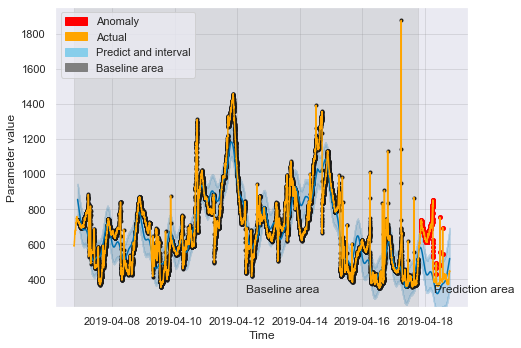

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-04-12 06:58:44.732000 and 2019-04-16 18:58:44.732000


<Figure size 432x288 with 0 Axes>

In [15]:
# Single instance example
df_p, df_pred = prophet(
            df_dev,
            device,
            parameter='co2',
            begin='2019-04-06',
            end='2019-04-18',
            sampling_period_min=1,
            graph=1, 
            predict_day=1,
            interval_width=0.6,
            changepoint_prior_scale=0.01,
            daily_fo = 3
)
df_p.to_csv('df_p_04-17.csv')
df_pred.to_csv('df_pred_04-17.csv')

Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-04-07 to the 2019-04-19.
o Trained on the data from the 2019-04-07 to the 2019-04-18 (10 days).
o Predict from the 2019-04-18 to the 2019-04-19 (1 days).


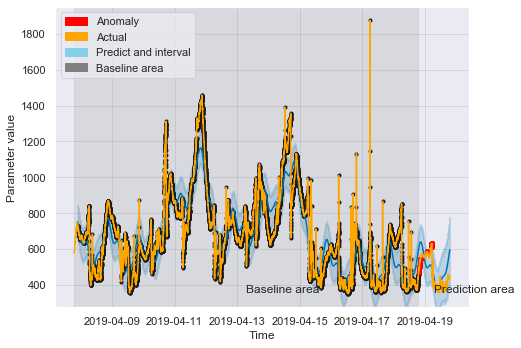

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-04-13 06:58:52.461000 and 2019-04-17 18:58:52.461000


<Figure size 432x288 with 0 Axes>

In [16]:
# Single instance example
df_p, df_pred = prophet(
            df_dev,
            device,
            parameter='co2',
            begin='2019-04-07',
            end='2019-04-19',
            sampling_period_min=1,
            graph=1, 
            predict_day=1,
            interval_width=0.6,
            changepoint_prior_scale=0.01,
            daily_fo = 3
)
df_p.to_csv('df_p_04-18.csv')
df_pred.to_csv('df_pred_04-18.csv')

Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-04-08 to the 2019-04-20.
o Trained on the data from the 2019-04-08 to the 2019-04-19 (10 days).
o Predict from the 2019-04-19 to the 2019-04-20 (1 days).


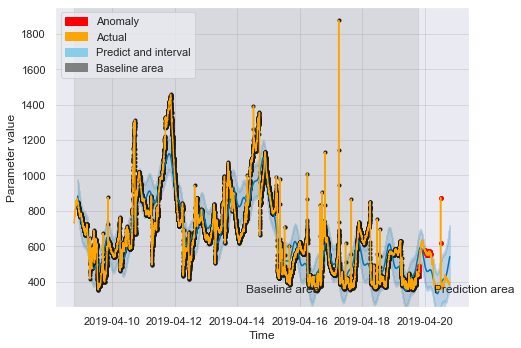

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-04-14 06:58:42.312000 and 2019-04-18 18:58:42.312000


<Figure size 432x288 with 0 Axes>

In [17]:
# Single instance example
df_p, df_pred = prophet(
            df_dev,
            device,
            parameter='co2',
            begin='2019-04-08',
            end='2019-04-20',
            sampling_period_min=1,
            graph=1, 
            predict_day=1,
            interval_width=0.6,
            changepoint_prior_scale=0.01,
            daily_fo = 3
)
df_p.to_csv('df_p_04-19.csv')
df_pred.to_csv('df_pred_04-19.csv')

Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-04-09 to the 2019-04-21.
o Trained on the data from the 2019-04-09 to the 2019-04-20 (10 days).
o Predict from the 2019-04-20 to the 2019-04-21 (1 days).


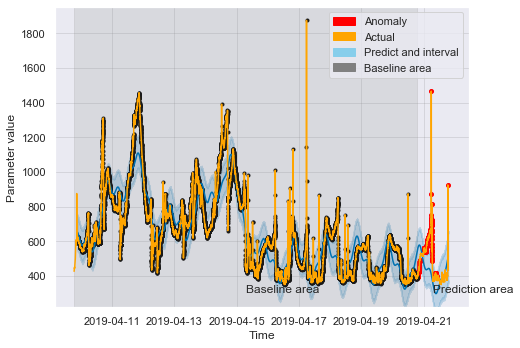

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-04-15 06:58:49.580000 and 2019-04-19 18:58:49.580000


<Figure size 432x288 with 0 Axes>

In [14]:
# Single instance example
df_p, df_pred = prophet(
            df_dev,
            device,
            parameter='co2',
            begin='2019-04-09',
            end='2019-04-21',
            sampling_period_min=1,
            graph=1, 
            predict_day=1,
            interval_width=0.6,
            changepoint_prior_scale=0.01,
            daily_fo = 3
)
df_p.to_csv('df_p_04-20.csv')
df_pred.to_csv('df_pred_04-20.csv')

Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-04-10 to the 2019-04-22.
o Trained on the data from the 2019-04-10 to the 2019-04-21 (10 days).
o Predict from the 2019-04-21 to the 2019-04-22 (1 days).


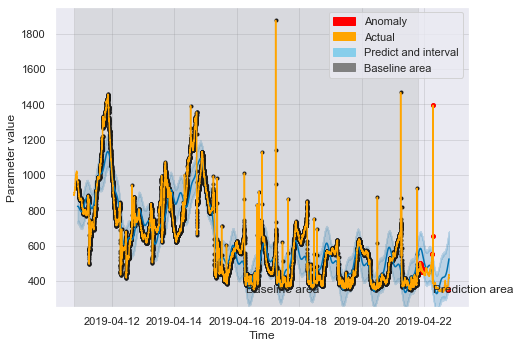

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-04-16 06:58:57.656000 and 2019-04-20 18:58:57.656000


<Figure size 432x288 with 0 Axes>

In [18]:
# Single instance example
df_p, df_pred = prophet(
            df_dev,
            device,
            parameter='co2',
            begin='2019-04-10',
            end='2019-04-22',
            sampling_period_min=1,
            graph=1, 
            predict_day=1,
            interval_width=0.6,
            changepoint_prior_scale=0.01,
            daily_fo = 3
)
df_p.to_csv('df_p_04-21.csv')
df_pred.to_csv('df_pred_04-21.csv')

Full dataset: 2019-03-07 to the 2019-05-01. Analysed data the 2019-04-11 to the 2019-04-23.
o Trained on the data from the 2019-04-11 to the 2019-04-22 (10 days).
o Predict from the 2019-04-22 to the 2019-04-23 (1 days).


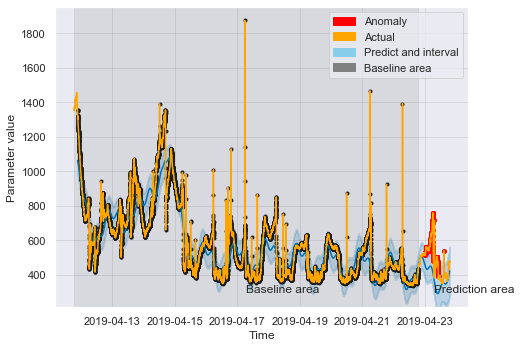

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-04-17 06:58:45.598000 and 2019-04-21 18:58:45.598000


<Figure size 432x288 with 0 Axes>

In [19]:
# Single instance example
df_p, df_pred = prophet(
            df_dev,
            device,
            parameter='co2',
            begin='2019-04-11',
            end='2019-04-23',
            sampling_period_min=1,
            graph=1, 
            predict_day=1,
            interval_width=0.6,
            changepoint_prior_scale=0.01,
            daily_fo = 3
)
df_p.to_csv('df_p_04-22.csv')
df_pred.to_csv('df_pred_04-22.csv')

## Conclusions and working directions:

* Prophet is a time series forecasting method method that can be used to predict the CO2 level over time.
* The comparison between the predicted and recorded data can be interpreted as follows:
    - **If the recorded data match the predicted CO2 level over time**: the resident exhibits most likely a normal daily activity. There is no reason to specifically check this person.
    - **If the recorded data differs from the predicted CO2 level over time**:
        - *If the difference lasts for several hours*: the resident does not have the typical activity. It may be worth to check if the resident need help. *See example on the left figure below*.
        - *If there are short transient deviations from the predicted CO2 level*: most likely, the transient deviations are not predicted because they are too small in duration, or happening at variable time points every day (ex: nightly bathroom break ), but could be a normal activity of the resident. In this case, it may be worth implementing an additional function to count the number of transients:
            - If the number of transient is not significantly different from the usual number of transients, it is not necessary to check the person.
            - If the number of transient is significantly different from the usual number of transients, it may be worth to check the person. *See example on the right figure below*.
* It may be worth to run, for each day to predict, a GridSearch using different training periods (8, 10, or more days), since it has a great impact on the prediction quality.
            
![Forecast_examples.png](Forecast_examples.png)
**Figure 2: Example traces of normal (left figure) and abnormal (right figure) activities.**
            

**Ideas of working directions**:

- Improve prediction:
    - Use more parameters for prophet by following this [tutorial](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3). In praticular, the weekdays can be taken in account, with a potential drawback on the computational cost of prediction.
    - Optimize the hyperparameter tuning: Implement a RandomSearch or a function that run a new GridSearch using the best parameters found in the previous GridSearch.
    - Use a different forecasting method such as the [Seasonal ARIMA](https://medium.com/analytics-vidhya/sarima-forecasting-seasonal-data-with-python-and-r-2e7472dfad83).
- Quantify the frequency and area of short-term deviations from the predicted CO2 level:
    - Measure the mean frequency and mean area under the curve.
    - Set an alert when the short-term deviations from the predicted CO2 level are significantly different in frequency and area between the last day and the training period.